# Part 1: Stitching pairs of images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [132]:
from pathlib import Path
from skimage.io import imread as _imread
from skimage.color import rgb2gray


def imread(filename: str, as_gray: bool = False, bonus: str = None):
    """
    Read image data for this part.
    
    Args:
        filename (str): Filename in the data folder corresponding to this part.
        as_gray (bool, optional): Return the image as grayscale [0, 1].
        bonus (str, optional): Bonus dir 
    """
    path = Path("part1") 
    if bonus:
        path = path / 'bonus' / bonus
    path /= filename

    im = _imread(path)
    if as_gray and (im.ndim == 3):
        return rgb2gray(im)
    else:
        return im


In [3]:
import cv2 as cv
from skimage.feature.util import FeatureDetector, DescriptorExtractor
from skimage.util import img_as_ubyte


class SIFT(FeatureDetector, DescriptorExtractor):
    """
    Wrapper class for OpenCV to use scikit-image detector-extractor.
    
    Args:
        n_features (int, optional): The number of best features to retain. 
        n_octave_layers (int, optional): The number of layers in each octave.
        contrast_threshold (float, optional): The contrast threshold used to filter out 
            weak features in semi-uniform (low-contrast) regions.
        edge_threshold (float, optional): The threshold used to filter out edge-like 
            features. 
        sigma (float, optional): The sigma of the Gaussian applied to the input image 
            at the 0th octave.
    """

    def __init__(
        self,
        n_features=100,
        n_octave_layers=3,
        contrast_threshold=0.04,
        edge_threshold=10,
        sigma=1.6,
    ) -> None:
        self.detector = cv.SIFT_create(
            nfeatures=n_features,
            nOctaveLayers=n_octave_layers,
            contrastThreshold=contrast_threshold,
            edgeThreshold=edge_threshold,
            sigma=sigma,
        )

        self.keypoints = None
        self.descriptors = None

    def detect(self, image) -> None:
        # cv only takes in 8U
        image = img_as_ubyte(image)
        self.keypoints_ = self.detector.detect(image)

        # extract relevant info from cv structure
        self.keypoints = np.array([keypoint.pt[::-1] for keypoint in self.keypoints_])

    def extract(self, image, keypoints=None) -> None:
        if keypoints is not None:
            raise NotImplementedError(f"'keypoints' has no effect, using cached result")

        # cv only takes in 8U
        image = img_as_ubyte(image)
        _, self.descriptors = self.detector.compute(image, self.keypoints_)


In [4]:
from scipy.spatial.distance import cdist


def swap_by(v, cond):
    v[cond, 0], v[cond, 1] = v[cond, 1], v[cond, 0]
    return v


def ubcmtach(desc1, desc2, threshold):
    """
    Matches two sets of SIFT descriptors.append
    
    This function uses the algorithm suggested by D. Lowe to reject matches that are too ambiguous.
    
    Args:
        desc1 : 
        desc2 :
        threshold (float): 

    Returns:
        TBD
    """
    dist2 = cdist(desc1, desc2, metric="sqeuclidean")

    # find 1st and 2nd closest match distance
    index_closest = np.argpartition(dist2, 2)[:, :2]
    dist_closest = np.take_along_axis(dist2, index_closest, axis=-1)
    # sort in each partition
    need_swap = dist_closest[:, 0] > dist_closest[:, 1]
    index_closest = swap_by(index_closest, need_swap)
    dist_closest = swap_by(dist_closest, need_swap)

    # compare ratio
    index_closest_mask = dist_closest[:, 0] * threshold < dist_closest[:, 1]

    matches = [
        (m0, m1)
        for m0, (m1, mask) in enumerate(zip(index_closest[:, 0], index_closest_mask))
        if mask
    ]
    matches = np.array(matches)

    return matches, dist_closest[index_closest_mask, 0]


In [143]:
from skimage.measure.fit import BaseModel
from skimage.transform._geometric import _center_and_normalize_points

class HomographyModel(BaseModel):
    def estimate(self, src, dst) -> bool:
        """
        Estimate homography model from data.

        Args:
            data ((N, 4) array): N points in a 2D space, arrange in (x1, y1, x2, y2).

        Returns:    
            bool: True if model sucessfully estimates.
        """
        n = len(src)

        A1 = np.hstack(
            [
                src,
                np.ones((n, 1)),
                np.zeros((n, 3)),
                -dst[:, 0][:, np.newaxis] * src,
                -dst[:, 0][:, np.newaxis],
            ]
        )

        A2 = np.hstack(
            [
                np.zeros((n, 3)),
                src,
                np.ones((n, 1)),
                -dst[:, 1][:, np.newaxis] * src,
                -dst[:, 1][:, np.newaxis],
            ]
        )

        A = np.empty((2 * n, A1.shape[-1]))
        A[0::2, :] = A1
        A[1::2, :] = A2

        _, _, vh = np.linalg.svd(A, full_matrices=False)
        if np.isclose(vh[-1, -1], 0):
            return False

        # save the H
        self.params = np.reshape(vh[-1, :], (3, 3))

        return True

    def residuals(self, src, dst):
        """
        Determine residuals of data to model.

        Args:
            src ((N, 2) array): Source coordinates.
            dst ((N, 2) array): Destination coordinates

        Returns:
            (N, ) array: 
        """
        return np.hypot(*(self.predict(src) - dst).T)

    def predict(self, data):
        """
        Predict x-y coordinates using the estimated model.

        Args:
            data ((N, 2) array):

        Returns:
            (N, 2) array: 
        """
        n = len(data)

        data = np.hstack([data, np.ones((n, 1))])
        data_fit = data @ self.params.T
        # convert back from homogeneous coordinate
        data_fit = data_fit[:, :-1] / data_fit[:, -1][:, np.newaxis]

        return data_fit

def ransac(
    data,
    model_class,
    min_samples,
    residual_threshold,
    max_trials=100,
    random_state=None,
):
    """
    RANSAC

    Args:
        data ((N, 2) array): 
        model_class :
        min_samples (int): Minimum number of data points to fit the model.
        residual_threshold (float): Maximum distance for a data point to be classified 
            as an inlier.
        max_trials (int, optional): Maximum number of iterations for RANSAC.
        random_State ({None, int, `numpy.random.Generator`}, optional): A seed to 
            initialize the BitGenerator.
    """
    n_samples = len(data)

    # model for this dataset, following skimage.measure.fit.BaseModel
    model = model_class()

    random_state = np.random.default_rng(random_state)

    best_inliers_num = 0
    best_residuals_sum = np.inf
    best_inliers = []

    for i_trial in range(max_trials):
        # select subset, forbit duplicate item
        sampling_mask = random_state.choice(n_samples, min_samples, replace=False)
        samples = data[sampling_mask, :]

        success = model.estimate(samples[:, 2:], samples[:, :2])
        if not success:
            # fail to fit for some reason
            continue
        residuals = np.abs(model.residuals(data[:, 2:], data[:, :2]))

        inliers = residuals < residual_threshold
        residuals_sum = np.sum(residuals ** 2)

        inliers_num = np.count_nonzero(inliers)

        if (
            # more inliers
            (inliers_num > best_inliers_num)
            # same number of inliers, but less residuals sum
            or (
                (inliers_num == best_inliers_num)
                and (residuals_sum < best_residuals_sum)
            )
        ):
            best_inliers = inliers
            best_residuals_sum = residuals_sum
            best_inliers_num = inliers_num

            # TODO early stop conditions

    if best_inliers.any():
        print(f".. best_residual_sum={best_residuals_sum:.6f}")
        print(f".. best_inliers_num={best_inliers_num}")
        
        # estimate the model with all inliers
        data_inliers = data[best_inliers, :]
        model.estimate(data_inliers[:, 2:], data_inliers[:, :2])
    else:
        model = None
        best_inliers = None
        
    return model, best_inliers


image 0, 1001 keypoints
image 1, 1000 keypoints
0<>1, 114 matches


/tmp/ipykernel_829/1726068139.py:78: RuntimeWarning: divide by zero encountered in true_divide
  data_fit = data_fit[:, :-1] / data_fit[:, -1][:, np.newaxis]


.. best_residual_sum=7420258.627920
.. best_inliers_num=32
0<>1, [ransac] 32 matches
[[], <__main__.HomographyModel object at 0x7f4826d6e3d0>]


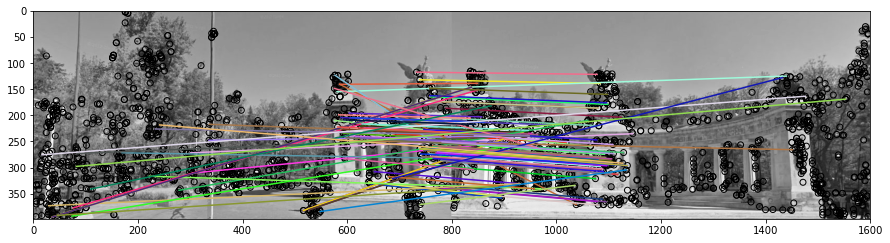

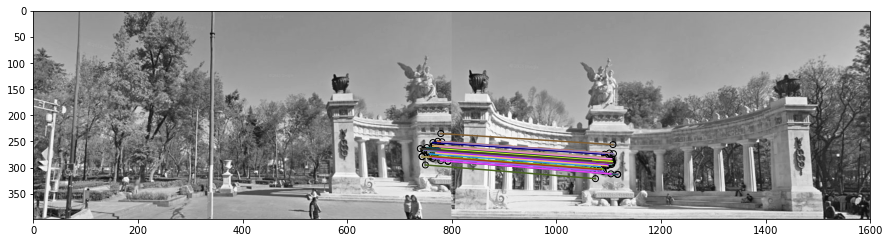

In [144]:
# test SIFT
from matplotlib.patches import Circle
from skimage.feature import plot_matches
from skimage.transform import warp, EuclideanTransform, ProjectiveTransform


def register_images(
    images,
    method="first",
    # SIFT feature extraction
    n_features=1000,
    # putative matching
    extraction_ratio=1.5,
    # debug features
    show_features=False,
    show_putative_matches=False,
    show_ransac=False,
    show_homography_fitting=False,
):
    """
    Register all images with respect to the first one.

    Args:
        images (list of 2D array): Images to register.
        mode ({'first', 'consecutive'}, str, optional): Image pair matching method.
        show_features (bool, optional): Show detected SIFT features.
        show_putative_matches (bool, optional): Show putative match results.
        show_ransac (bool, optional): Show RANSAC inliers matches.
        show_homography_fitting (bool, optional): Show homography fitting result.

    Returns:
        TBD
    """
    # TODO sanity check for `mode`

    detector = SIFT(
        n_features=n_features,
        n_octave_layers=4,
        contrast_threshold=0.04,  # Harris response
        edge_threshold=10,
        sigma=1.6,
    )

    # main feature variables
    keypoints = []
    descriptors = []
    matches = [[]]  # ignore first comparison
    models = [[]]

    keypoints_raw = []

    for i, image in enumerate(images):
        detector.detect(image)
        keypoints.append(detector.keypoints)
        print(f"image {i}, {len(detector.keypoints)} keypoints")
        keypoints_raw.append(detector.keypoints_)

        detector.extract(image)
        descriptors.append(detector.descriptors)

    if show_features:
        # show all images in horizontal
        fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
        for i, (im, kp, kp_raw) in enumerate(zip(images, keypoints, keypoints_raw)):
            ax[i].imshow(im, cmap="gray")
            for (y, x), kp in zip(kp, kp_raw):
                c = Circle((x, y), kp.size, color="r", fill=False)
                ax[i].add_patch(c)
            fig.canvas.flush_events()

    # find matches
    i_ref = 0
    for i_src in range(1, len(images)):
        new_matches, score = ubcmtach(
            descriptors[i_ref], descriptors[i_src], extraction_ratio
        )
        print(f"{i_ref}<>{i_src}, {len(new_matches)} matches")
        matches.append(new_matches)

        if method == "first":
            # do nothing, keep using the first image
            pass
        elif method == "consecutive":
            i_ref = i_src

    if show_putative_matches:
        i_ref = 0
        for i_src in range(1, len(images)):
            fig, ax = plt.subplots(figsize=(15, 5))
            plot_matches(
                ax,
                images[i_ref],
                images[i_src],
                keypoints[i_ref],
                keypoints[i_src],
                matches[i_src],
            )
            fig.canvas.flush_events()

            if method == "consecutive":
                i_ref = i_src

    # build data array for RANSAC
    i_ref = 0
    for i_src in range(1, len(images)):
        m_ref = keypoints[i_ref][matches[i_src][:, 0], :]
        m_src = keypoints[i_src][matches[i_src][:, 1], :]

        # flip from y-x to x-y
        data = np.hstack([m_ref[:, ::-1], m_src[:, ::-1]])

        model, inliers = ransac(
            data,
            HomographyModel,
            min_samples=4,
            residual_threshold=1,
            max_trials=10000,
        )
        print(f"{i_ref}<>{i_src}, [ransac] {np.count_nonzero(inliers)} matches")
        models.append(model)

        # update match result with inliers-only
        matches[i_src] = matches[i_src][inliers, :]

        if show_ransac:
            fig, ax = plt.subplots(figsize=(15, 5))
            plot_matches(
                ax,
                images[i_ref],
                images[i_src],
                keypoints[i_ref],
                keypoints[i_src],
                matches[i_src],
            )

        if show_homography_fitting:
            # calculate target match
            m_src = m_src[inliers, :]
            m_dst_fit = model.predict(m_src[:, ::-1])[:, ::-1]

            # show fitting result
            fig, ax = plt.subplots(figsize=(15, 5))
            plot_matches(
                ax,
                images[i_ref],
                images[i_src],
                m_dst_fit,
                m_src,
                np.array([(i, i) for i in range(len(m_src))]),
            )

        if method == "consecutive":
            i_ref = i_src

    return models


def stitch_images(images, models, method="first"):
    def shape_to_corners(shape):
        ny, nx = shape
        return np.vstack([(0, 0), (nx, 0), (nx, ny), (0, ny), (0, 0)])

    # determine final output size
    i_ref = 0
    for i_src in range(1, len(images)):
        corners_ref = shape_to_corners(images[i_ref].shape)
        corners_src = shape_to_corners(images[i_src].shape)
        corners_src = models[i_src].predict(corners_src)
        
        # determine final output size
        extents = np.vstack([corners_ref, corners_src])
        extent_max, extent_min = np.max(extents, axis=0), np.min(extents, axis=0)

    raise RuntimeError

    # build output coordinate for each transformed image
    ny, nx = images[1].shape
    extent0 = np.vstack([(0, 0), (nx, 0), (nx, ny), (0, ny), (0, 0)])
    extents = [extent0, model.predict(extent0)]

    # DEBUG
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.invert_yaxis()
    # reference
    xs, ys = zip(*extent0)
    ax.plot(xs, ys)
    ax.scatter(xs[0], ys[0], marker="o")
    # warped
    xs, ys = zip(*extents[1])
    ax.plot(xs, ys)
    ax.scatter(xs[0], ys[0], marker="o")
    # fix axis orientation
    ax.axis("equal")

    extents = np.vstack(extents)
    # determine the final output size
    extent_max, extent_min = np.max(extents, axis=0), np.min(extents, axis=0)
    print(extents)
    shape = np.ceil(extent_max - extent_min).astype(int)
    shape = shape[::-1]
    print(f"output_shape(y,x)={shape}, offset(x,y)={extent_min}")
    # reference image need to sheift `extent_min`
    offset = EuclideanTransform(translation=-extent_min)

    H = ProjectiveTransform(model.params)
    print(model.params)

    im_warp = [
        warp(images[0], (offset).inverse, output_shape=shape),
        warp(images[1], (H + offset).inverse, output_shape=shape),
    ]

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for i, image in enumerate(im_warp):
        ax[i].imshow(image, cmap="gray")


images = [imread(f"{name}.jpg", as_gray=True) for name in ("left", "right")]
models = register_images(
    images,
    show_features=False,
    show_putative_matches=True,
    show_ransac=False,
    show_homography_fitting=True,
)

print(models)

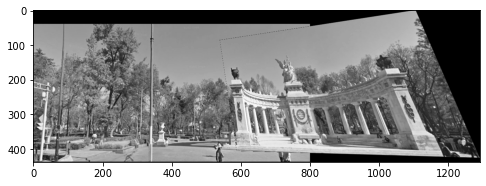

In [142]:
# test run, warp left side
from skimage.io import imsave

im_sum = im_warp[0] + im_warp[1]

im_sum = np.zeros_like(im_warp[0])
for im in im_warp:
    im_sum[im > 0] = im[im > 0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(im_sum, cmap="gray")

imsave('warped_summed.jpg', (im_sum * 255).astype(np.uint8))

image 0, 1000 keypoints
image 1, 1000 keypoints
image 2, 1000 keypoints
0<>1, 277 matches
1<>2, 349 matches


/tmp/ipykernel_829/1726068139.py:78: RuntimeWarning: divide by zero encountered in true_divide
  data_fit = data_fit[:, :-1] / data_fit[:, -1][:, np.newaxis]


.. best_residual_sum=4220259.644247
.. best_inliers_num=107
0<>1, [ransac] 107 matches
.. best_residual_sum=3325808.598971
.. best_inliers_num=112
1<>2, [ransac] 112 matches


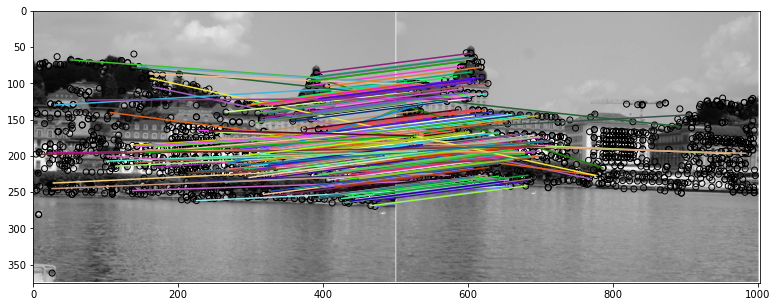

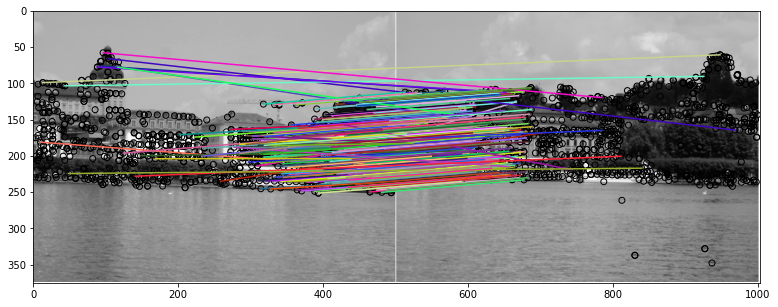

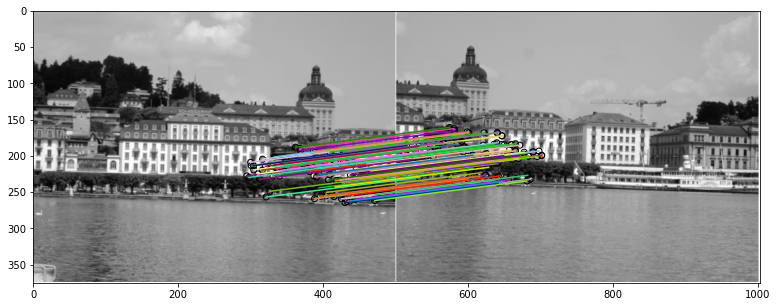

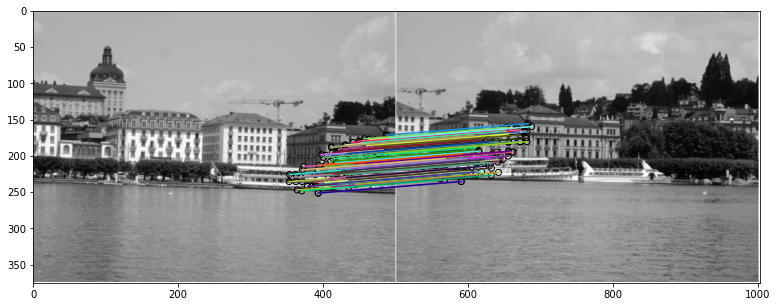

In [145]:
images = [imread(f"{i+1}.jpg", as_gray=True, bonus="pier") for i in range(3)]
models = register_images(
    images,
    method="consecutive",
    show_features=False,
    show_putative_matches=True,
    show_ransac=False,
    show_homography_fitting=True,
)


In [ ]:
# Provided code - nothing to change here


def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect("equal")
    ax.imshow(res, cmap="gray")

    ax.plot(inliers[:, 0], inliers[:, 1], "+r")
    ax.plot(inliers[:, 2] + img1.shape[1], inliers[:, 3], "+r")
    ax.plot(
        [inliers[:, 0], inliers[:, 2] + img1.shape[1]],
        [inliers[:, 1], inliers[:, 3]],
        "r",
        linewidth=0.4,
    )
    ax.axis("off")


# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


In [6]:
# See assignment page for the instructions!
